# Introduction

In this tab, I will go over two datasets: Record dataset and Vectorized Text dataset. Fortunately, my record dataset is consisted of categorical data which is a perfect dataset to perform the Association Rule Mining(a.k.a. ARM) method. Also, I would like to perform the ARM on my text data achieved from using the News API, and see how the model builds up the network map. Furthermore, we will observe the relevancy between the positive and negative labels for the text data using sentiment intensity analyzer. 

For the record data which contains categorical data, I will be using mlxtend library and for text data I will be using apyori library. 

# Theory

Association Rule Mining is an un-supervised rule-based machine learning method for discovering statistically relevant inter-relations between variables in large datasets. In other words, it is used to find relationships of interests among variables in a big data set. We learnt in class that ARM is most often used for transactional data. To illustrate this further - if we have 10 rows with items separated by commas, ARM will look for patterns of when separate items are bought together, helping us infer the relationships between items. A use case could be: you are trying to market beer to shoppers but don't know where to place it in the store. With a little association rule mining, you learn that beer is often bought with diapers, so you decide to place the beer section closer to the diapers. 

For this project, I won't be using ARM for transaction data. Instead, I will be using it to find relationships between record data and text data, since ARM is commonly suitable for non-numeric, categorical data and text data. Using ARM, we can find the most often used words and the web that interconnects them all. Although this won't lead to predictions, it can help us understand relationships between the data; this could lead to new ways of looking at the content of our dataset.

To briefly explain the basic process of the use of ARM in text data, we will be using the WordLemmatizer and SentimentIntensityAnalyzer objects in NLTK package for reading and cleaning the data. By using this method, we will be able to get the results of positive and negative labels for the text data. Then, we will use the apriori algorithm in order to train the data. Apriori algorithm identifies the frequent individual items in the database and extend them to larger and larger item sets as long as those item sets appear sufficiently often in the database. In other words, apriori algorithm is used to make associaton rules by searching data for frequent if-then patterns and by using Support and Confidence to defince what the most important relationships are. Support is an indication of how frequently the items appear in the data. Confidence indicates the number of times the if-then statements are found true. For visualizing the network web, we will use the NetworkX package. 


# Methods

## Text Data

Instead of using News API data, I chose to use Wikipedia API to gather the text data. The reason for this is because Wikipedia text contents contain words more related to the topic and for this reason, we can see more clear relationship within the network web. I have tried using News API, but unfortunately the text I gathered via News API contained unrelated words such as politics-related data. 

If our goal is to see the text relationship among the wildlife, climate change related news worldwide, we might have to use News API and see how the media observe certain topics. But since our goal is to see clearer relationship regrading wildlife, threatened species and climate change, I thought Wikipedia API would be the most appropriate API for this tab. 

### Read the Data

First step is to load the text data. For the sentiment column, please refer to the 'Data Gathering' tab: [data-gathering](data_gathering.ipynb)

In [87]:
# import required libraries
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from apyori import apriori
import networkx as nx
import re

nltk.download('vader_lexicon', quiet = True)
nltk.download('stopwords', quiet = True)
nltk.download('wordnet', quiet = True)
nltk.download('punkt', quiet = True)
nltk.download('omw-1.4', quiet = True)

# import the file and see the first 5 lines
texts = pd.read_csv('./data/wiki_textdata.csv')
texts.head()

,text,label,sentiment
0,pursuant eagle feather law title 50 part 22 co...,Wildlife,0.9670
1,founding 1896 work division biological survey ...,Wildlife,0.9468
2,edward goldman survey made perfectly clear pos...,Wildlife,-0.9313
3,1940 1970 fws 1956 usfws operated fleet seagoi...,Wildlife,0.0000
4,upon creation 1940 fws inherited bof fleet bro...,Wildlife,0.6369


### Visualize the Sentiments

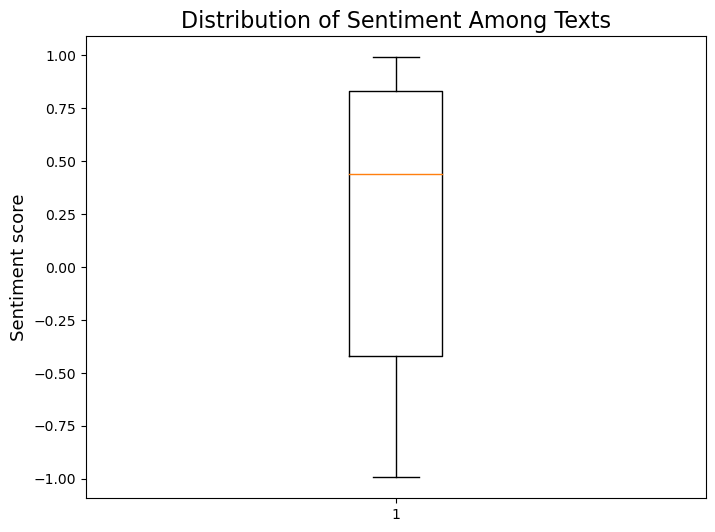

In [88]:
# see the distribution of the sentiment
plt.figure(figsize=(8,6))
plt.boxplot(texts['sentiment'])
plt.ylabel('Sentiment score', fontsize=13)
plt.title('Distribution of Sentiment Among Texts', fontsize=16);

In [89]:
text_content = texts['text']
text_path = './data/wiki_textcontent.txt'

with open(text_path, 'w', encoding='utf-8') as file:
    for content in text_content:
        file.write(f"{content}\n\n")  

In [90]:
file_path = './data/wiki_textcontent.txt'  # Replace with your file path
num_lines = 0

with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        num_lines += 1

print(f"The number of lines in the file is: {num_lines}")

The number of lines in the file is: 1628


                label  sentiment
0      Climate Change   0.216201
1  Threatened Species   0.100653
2            Wildlife   0.322251


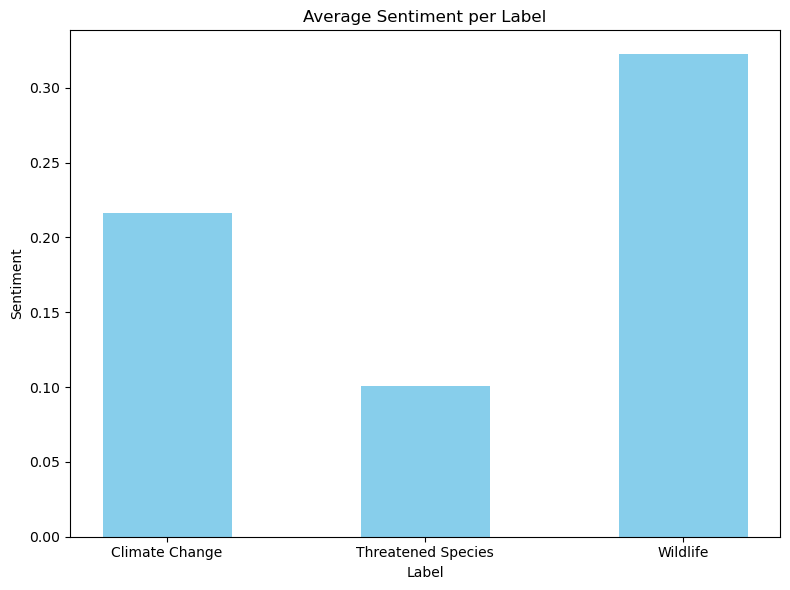

In [91]:
label_sentiment = texts[['label', 'sentiment']]
average_sentiment = label_sentiment.groupby('label')['sentiment'].mean().reset_index()

print(average_sentiment)

plt.figure(figsize=(8, 6))
plt.bar(average_sentiment['label'], average_sentiment['sentiment'], color='skyblue', width = 0.5)
plt.xlabel('Label')
plt.ylabel('Sentiment')
plt.title('Average Sentiment per Label')
plt.tight_layout()

Based on the graph above, we can see that 'Threatened Species' had the most negative sentiment averagae value among the three labels. On the other hand, 'Wildlife' had to most highest sentiment average score. Although Wildlife had the highest sentiment score, considering the absolute value of each, we cannot say that Wildlife has positive sentiment because the value itself is only approximately 0.35.

The graph below is a graph of all the sentiments of Wildlife label. We can also see that the average score is approximately 0.35. Also, compared to the sentiment values, we can take a look at the actual words in the corpus via WordCloud. 

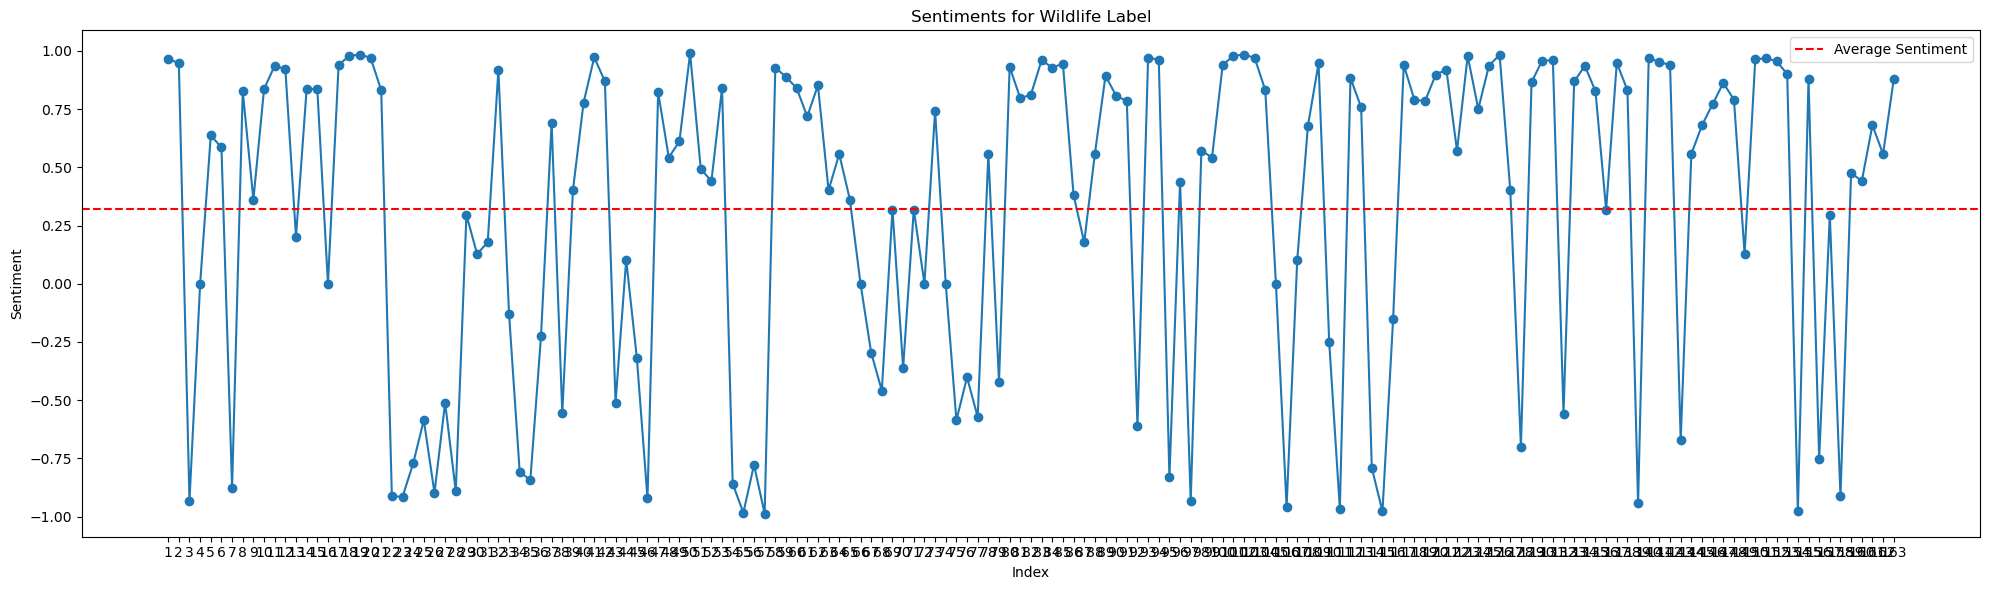

In [92]:
wildlife_sentiments = texts[texts['label'] == 'Wildlife']['sentiment']
average_wildlife = wildlife_sentiments.mean()

plt.figure(figsize=(20, 6))
plt.plot(wildlife_sentiments, marker='o', linestyle='-')
plt.axhline(y=average_wildlife, color='red', linestyle='--', label='Average Sentiment')
plt.xlabel('Index')
plt.ylabel('Sentiment')
plt.title('Sentiments for Wildlife Label')
plt.xticks(range(len(wildlife_sentiments)), range(1, len(wildlife_sentiments) + 1))
plt.tight_layout()
plt.legend()  
plt.show()

In [93]:
#| code-overflow: wrap
# word cloud generation function
def generate_word_cloud(my_text):
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    
    def plot_cloud(wordcloud): 
        plt.figure(figsize=(40,30))
        plt.imshow(wordcloud)
        plt.axis("off")
        
    # generate a word cloud
    wordcloud = WordCloud(
        width=2500,
        height=1500,
        random_state=1,
        background_color='skyblue',
        colormap='Pastel1',
        collocations=False,
        stopwords=STOPWORDS).generate(my_text)
        
    plot_cloud(wordcloud)
    plt.show()

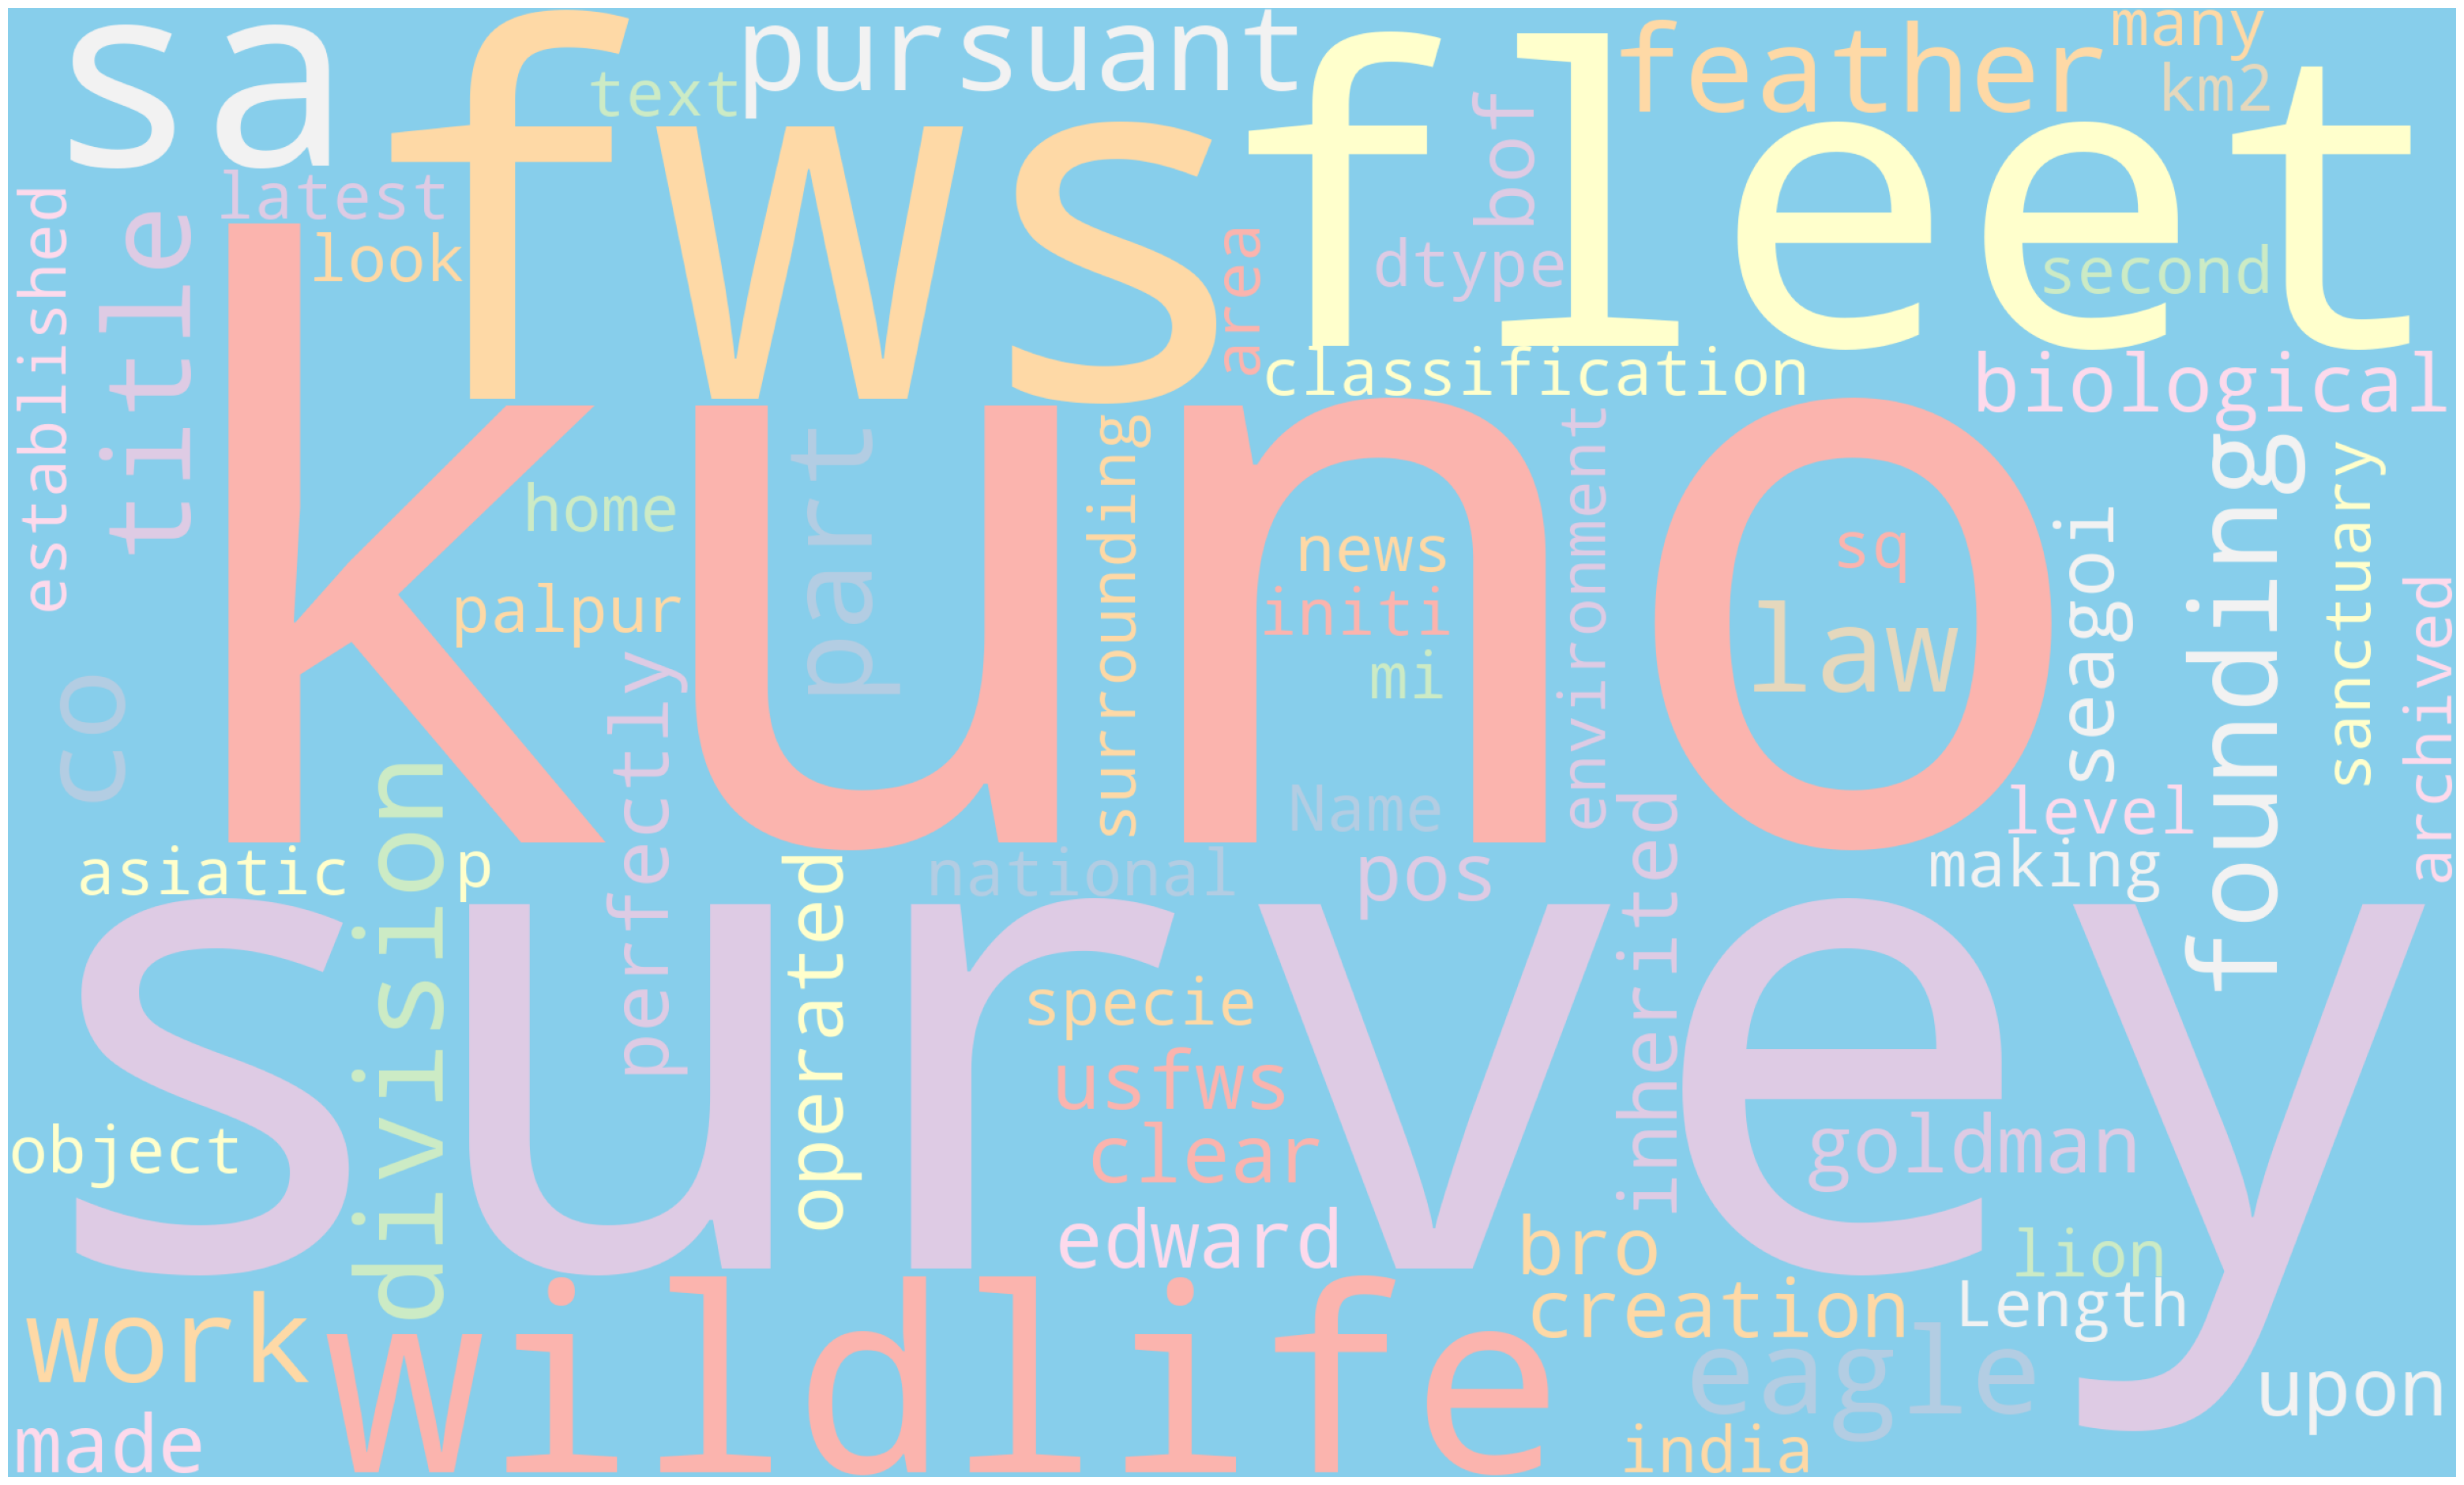

In [97]:
wildlife_texts = str(texts[texts['label'] == 'Wildlife']['text'])
generate_word_cloud(wildlife_texts)

We cannot see a strong correlation with the actual words in the WordCloud and the wildlife topic itsef, but we can find some positive words such as 'perfectly' and 'sanctuary', and some negative words such as 'wildlife'. Also, based on the WordCloud, we can see that lion and eagle would probably have a strong correlation with wildlife.  

### ARM

In [98]:
# turn sentences into lists of words and put those lists into a list
sepSent = [text.split() for text in texts['text']]

# results needed for ARM plot
results = list(apriori(sepSent, min_support=0.03, min_confidence=0.02, min_length=1, max_length=2))
print(len(results))

920


In [99]:
### These functions are coming from lab 6.1, I did not write most of them

# reformat the apriori output into a df with columns "rhs", "lhs", "supp", "conf", "supp x conf", "lift"
def reformat_results(results):
    keep=[]
    for i in range(0,len(results)):
        for j in range(0,len(list(results[i]))):
            if(j>1):
                for k in range(0, len(list(results[i][j]))):
                    if(len(results[i][j][k][0])!=0):
                        rhs=list(results[i][j][k][0])
                        lhs=list(results[i][j][k][1])
                        conf=float(results[i][j][k][2])
                        lift=float(results[i][j][k][3])
                        keep.append([rhs,lhs,supp,conf,supp*conf,lift])
            if(j==1):
                supp=results[i][j]

    return pd.DataFrame(keep, columns=['rhs','lhs','supp','conf','supp X conf','lift'])

def convert_to_network(df):
    print(df.head())

    #BUILD GRAPH
    G = nx.DiGraph()  # DIRECTED
    for row in df.iterrows():
        # for column in df.columns:
        lhs="_".join(row[1][0])
        rhs="_".join(row[1][1])
        conf=row[1][3]; #print(conf)
        if(lhs not in G.nodes): 
            G.add_node(lhs)
        if(rhs not in G.nodes): 
            G.add_node(rhs)

        edge=(lhs,rhs)
        if edge not in G.edges:
            G.add_edge(lhs, rhs, weight=conf)

    # print(G.nodes)
    # print(G.edges)
    return G

def plot_network(G):
    #SPECIFIY X-Y POSITIONS FOR PLOTTING
    pos=nx.random_layout(G)

    #GENERATE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)

    #assign colors based on attributes
    weights_e 	= [G[u][v]['weight'] for u,v in G.edges()]

    #SAMPLE CMAP FOR COLORS 
    cmap=plt.cm.get_cmap('Blues')
    colors_e 	= [cmap(G[u][v]['weight']*10) for u,v in G.edges()]

    #PLOT
    nx.draw(
    G,
    edgecolors="black",
    edge_color=colors_e,
    node_size=2000,
    linewidths=2,
    font_size=8,
    font_color="white",
    font_weight="bold",
    width=weights_e,
    with_labels=True,
    pos=pos,
    ax=ax
    )
    plt.title('Relationships Between Words in Text Data', fontsize=24)
    plt.show()

         rhs        lhs      supp      conf  supp X conf      lift
0      [100]  [climate]  0.031941  0.604651     0.019313  1.183140
1  [climate]      [100]  0.031941  0.062500     0.001996  1.183140
2      [100]     [year]  0.031941  0.604651     0.019313  3.592599
3     [year]      [100]  0.031941  0.189781     0.006062  3.592599
4     [2010]   [change]  0.031941  0.764706     0.024425  1.629504


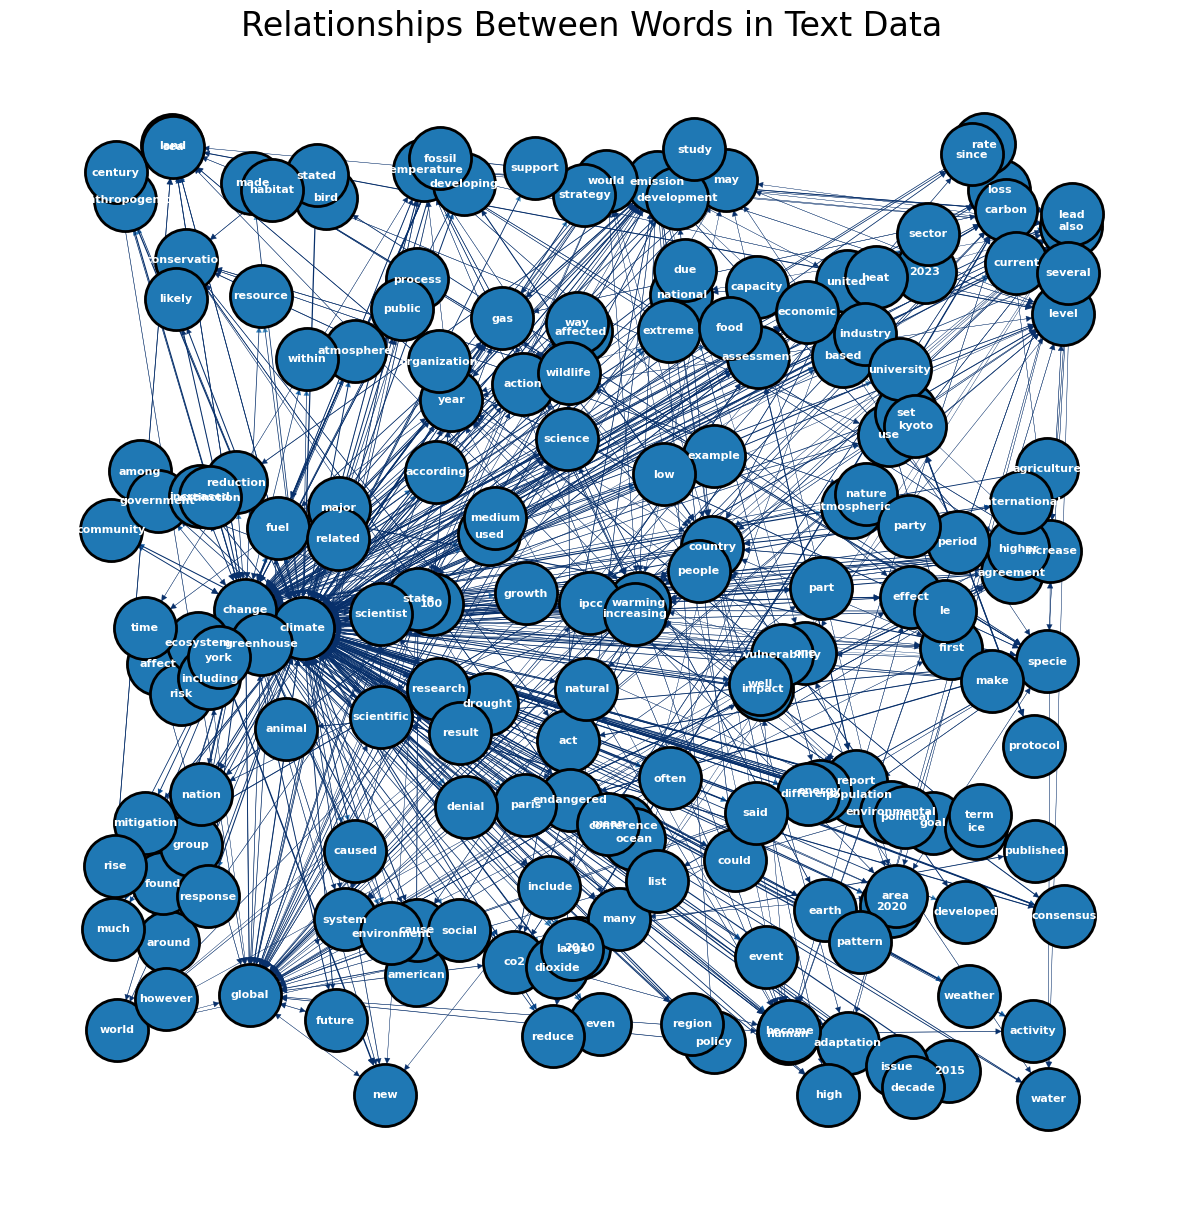

In [100]:
# plot the network web
pd_results=reformat_results(results)
G=convert_to_network(pd_results)
plot_network(G)

The network web graph above is hard to see, so for a simpler version, I will manipulate the Support and Confidence variables. 

59
         rhs        lhs      supp      conf  supp X conf      lift
0     [also]   [change]  0.116708  0.465686     0.054349  0.992326
1   [change]     [also]  0.116708  0.248691     0.029024  0.992326
2     [also]  [climate]  0.122850  0.490196     0.060221  0.959182
3  [climate]     [also]  0.122850  0.240385     0.029531  0.959182
4   [change]  [climate]  0.412776  0.879581     0.363070  1.721104


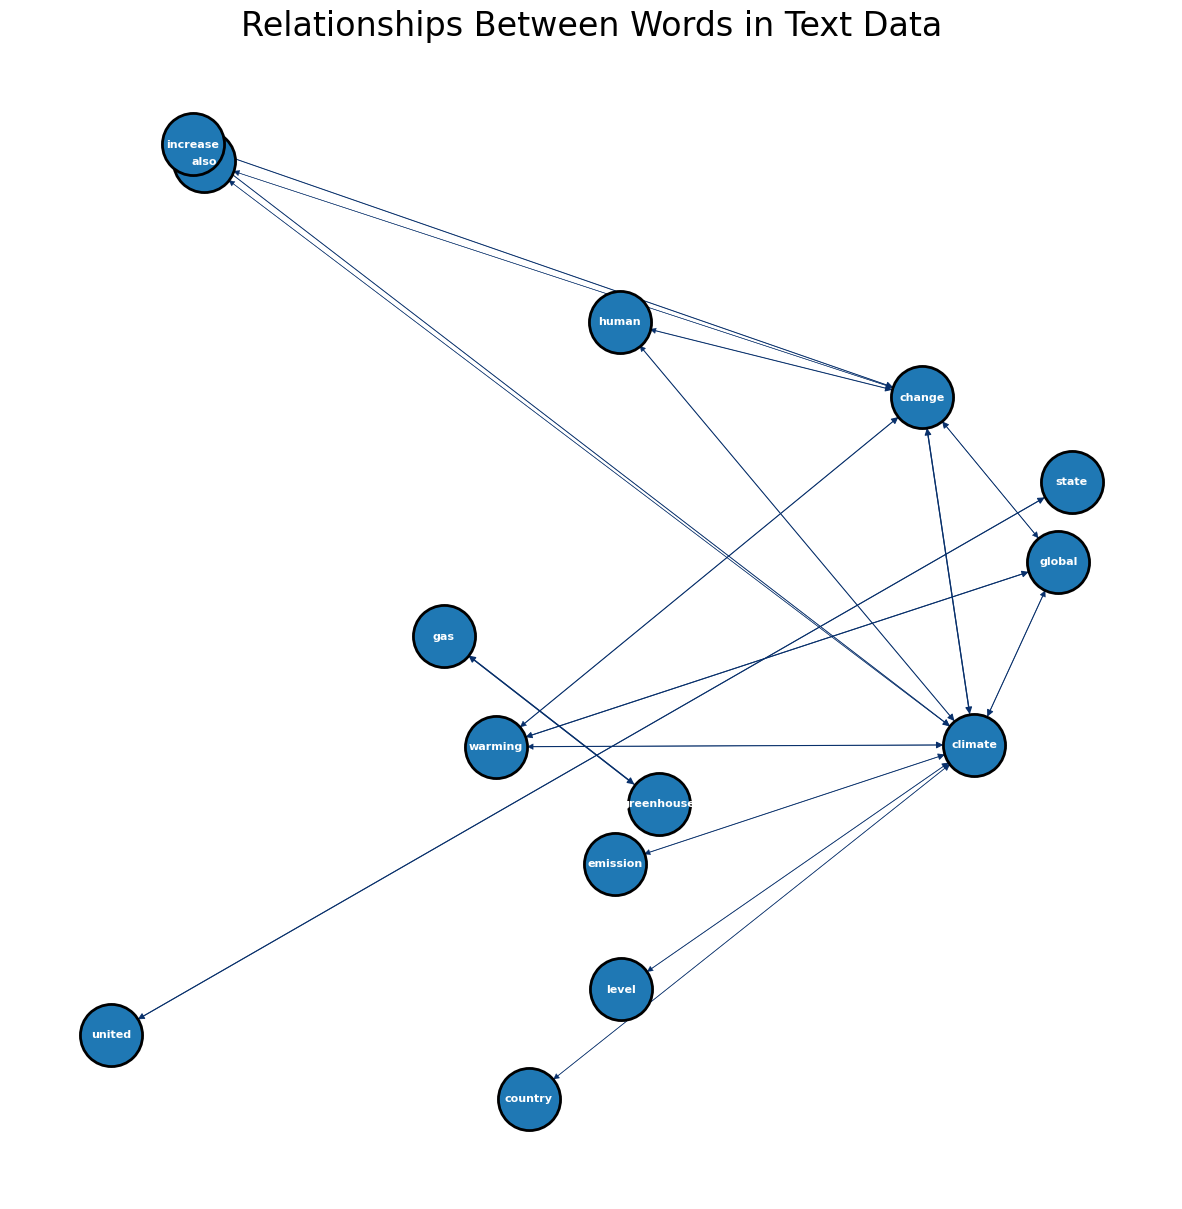

In [65]:
simple = list(apriori(sepSent, min_support=0.1, min_confidence=0.1, min_length=1, max_length=2))
print(len(simple))

# plot the network web
pd_results=reformat_results(simple)
G=convert_to_network(pd_results)
plot_network(G)

# Results
For our relationship web, we see the most common words from the texts and their relationships to each other. It makes perfect sense that Wikipedia text samples regarding wildlife and climate change result in seeing words such as: climate, animal, warming, atmosphere, rise, etc. It seems that the words climate, global, warming, increase, and human are the ones that most often coccur with other words. Although this graphs shows the relationships between words at the most general level, it could be useful to search for the relationships between specific words to understand the sentiment behind certain topics. For example, we could take the United States and see if it leads us to words climate change.

# Conclusions
Using ARM to see how your text data is interconnected can be a fun experiment, and probably a useful one in certain cases. That being said, my goal for this project is to create a model that can predict team the threatened status of certain species, so this type of model is not the way to go. Despite this not being a proper method for my problem, it could be useful for transaction data (as previously mentioned) or perhaps with text from a book (as we did in the lab assignment). Creating such a plot could lead to understanding the themes from the story and also the words most often associated with certain characters.